# Introduction

This post is the second in a three-part series describing my attempt to identify “safe” and “unsafe” foods for Irritable Bowel Disease (IBD; including Ulcerative Colitis and Crohn’s Disease) using various machine learning techniques and Python. Part II below walks through the methodologies of the study, as well as selections of code. The working project is available at https://github.com/ZaxR/ibd_diet_analysis and a [reliable] working view of the jupyter notebook is available via [nbviewer](https://nbviewer.jupyter.org/github/zaxr/ibd_diet_analysis/blob/master/IBD%20Diet%20Analysis.ipynb).

To recap and expand upon the questions this analysis is trying to answer (from Part I):
* Are there any identifiable sub-clusters of diet among the survey participants?
* Are there relationships between individual foods or groups of foods? If so, can we
   * find common nutrient links between those foods? or
   * use that information to reduce the dimensionality of our features and improve our ability to predict food tolerance/intolerance?
* Are there any nutrients, vitamins, or minerals that impact food tolerance?
* Can food tolerance/intolerance be predicted with a reasonable degree of accuracy (ideally probability) for an IDB sufferer with only a few “known” safe/unsafe foods?

# Materials & Assumptions

### Materials: 

* The data reflects 670 survey responses from IBD sufferers (collected by [IBDrelief.com](https://www.ibdrelief.com/ "IBDrelief.com")) where they were asked for each of 250 foods to answer how well he/she tolerated the food. The [online] survey utilizes a sliding scale to accept answer inputs (see the survey [here](https://www.ibdrelief.com/surveys/diet "Diet Survey")), which are stored as integer values in a range from 0 through 10. A checkbox for each question gives the participant the option to not answer questions individually. The survey was developed and data has been provided by ibdrelief.com.
* Nutrient information for each surveyed food from the USDA’s database (provided for free via their API).
* Python 3.6.1, with apyori, numpy, pandas, scikit-learn, scipy, and sqlite libraries for data analysis and jupyter notebook, matplotlib, and seaborn for data visualization.

### Assumptions and Limitations:

* Given that the analysis is beginning from survey data about well/not-so-well tolerated foods, our implicit assumption is that food impacts symptoms of IBD. However, as discussed in part I, research has found no foods that are specifically linked to IBD symptoms to-date; and the role of food generally in causing and/or triggering flares of IBD is poorly understood. That said, given anecdotal evidence and the strong belief in food-based symptom management by IBD patients, the results of this analysis remain relevant.
* That said, the quality of the survey data also has caveats, given that data (survey responses) is provided on a [self-reported basis](https://en.wikipedia.org/wiki/Self-report_study “Wikipedia link”) (e.g. participants’ responses are based on the limited knowledge/not knowing what they can/can’t eat and to what degree); potentially has other survey-design-based biases (e.g. [response biases](https://en.wikipedia.org/wiki/Response_bias “Wikipedia link”) such as [extreme responding bias](https://en.wikipedia.org/wiki/Response_bias#Extreme_responding “Wikipedia link”) and [sampling bias](https://en.wikipedia.org/wiki/Sampling_bias “Wikipedia link”)); and is subject to a number of other potential [cognitive biases](https://en.wikipedia.org/wiki/List_of_cognitive_biases “Wikipedia link”) (e.g. [illusory truth effect](https://en.wikipedia.org/wiki/Illusory_truth_effect “Wikipedia link”)).
* Lastly, the data set itself is very limited, with at most 570 usable surveys, only 19 of which are complete for all 250 foods (details in the data munging section below).

# IBD Survey Data Import, Munging and Initial Exploration

We'll begin by importing our first set of libraries, initialize our databse (commented out in the code, since we've already run it and only need to do so once), import our data, and validate that it has pulled correctly:

In [194]:
from IPython.display import display_html
import numpy as np
import pandas as pd
import scipy
import sqlite3

import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns


# create the database and tables, and import data
# %run db_builder.py

query = """SELECT uf.user_id, foods.name, uf.prep_id, uf.rating, uf.unknown
FROM users_to_foods uf, foods
WHERE uf.food_id = foods.id"""

# import data
conn = sqlite3.connect('food_db.db')
df = pd.read_sql(query, conn)

# default formatting for values
# pd.options.display.float_format = '{:,.0f}'.format
# pd.reset_option("^display")

def display_side_by_side(*args):
    # displays dfs side-by-side
    html_str=''
    for df in args:
        try:
            html_str+=df.to_html()
        except AttributeError:
            df2= pd.DataFrame(df)
            html_str+=df2.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding: 10px"'),raw=True)  

# confirm the number or rows (questions presented to users, in total) 
'Number of questions presented to users: {0}'.format(df.shape[0])

'Number of questions presented to users: 151899'

In [195]:
# confirm columns were pulled correctly
df.columns

Index(['user_id', 'name', 'prep_id', 'rating', 'unknown'], dtype='object')

With the data in a dataframe, we can pivot the data so each row represents a person's survey answers and we can see the number of participants. However, pivoting initially failed with coulmn set to 'name', since two names weren't unique. 'Pumpkin' was used for both pumpkin as a vegetable and pumpkin seed. 'Squash' was similarly used to reflect both the vegetable and the drink. We manually adjusted the names (to 'Pumpkin seed' and 'Squash (drink)', respectively) to prevent confusion and allow the intended pivot without accidentally aggregating answers to very different survey questions, and then pivoted:

In [196]:
df_pivot = df.pivot(index='user_id', columns='name')
df_pivot.tail()

prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3547             NaN    NaN         0.0     0.0   NaN         NaN     NaN   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3547           NaN       NaN       NaN       ...              NaN        NaN   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3547      0.0     NaN              NaN         NaN        NaN   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3547                 NaN          NaN             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Some NaNs (missing values) already appear in the table, which most likely means that not all food questions were asked for all surveys. Our supposition is that there were multiple iterations of the survey all stored in the data table without a column to label the survey number. Let's see how many surveys there were and what the size of each survey was:

In [197]:
q_count = {}
for i in df_pivot.isnull().sum(axis=1).sort_values(ascending=False):
    key = str(int((df_pivot.shape[1] - i)/3)) + '-question'  # divide by 3 to reflect the # of hierarchically indexed columns
    if key in q_count:
        q_count[key] += 1
    else:
        q_count[key] = 1

for k, v in q_count.items():
    print (k,'survey count: ', v)

40-question survey count:  29
61-question survey count:  14
80-question survey count:  24
125-question survey count:  8
164-question survey count:  16
199-question survey count:  8
249-question survey count:  1
250-question survey count:  570


We may still be able to use all of the data from the various iterations of the survey for analysis not sensitive to missing values, but for now we will limit our core data set to only the latest 250-question version of the exam, which leaves ~85% of the initial surveys (570/670).

In [198]:
df_old_surveys = df_pivot.loc[pd.isnull(df_pivot).any(1),:]
print('Confirmed number of old surveys, which are excluded (and saved for later): {0}'.format(df_old_surveys.shape[0]))
df_new_surveys = df_pivot.dropna()
print('Confirmed number of new surveys, which are included: {0}'.format(df_new_surveys.shape[0]))
df_new_surveys.tail()

Confirmed number of old surveys, which are excluded (and saved for later): 100
Confirmed number of new surveys, which are included: 570


prep_id                                                       \
name    Agave Nectar Almond Almond Milk Anchovy Apple Apple Juice Apricot   
user_id                                                                     
3544             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3558             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3559             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3563             0.0    0.0         0.0     0.0   0.0         0.0     0.0   
3566             0.0    0.0         0.0     0.0   0.0         0.0     0.0   

                                             ...          unknown             \
name    Artichokes Asparagus Aspartame       ...       Watercress Watermelon   
user_id                                      ...                               
3544           0.0       0.0       0.0       ...              0.0        0.0   
3558           0.0       0.0       0.0       ...              0.0        0.0   
3559           0.0       0.0       0.0       ...              1.0        0.0   
3563           0.0       0.0       0.0       ...              1.0        0.0   
3566           0.0       0.0       0.0       ...              1.0        0.0   

                                                               \
name    Wheat Whiskey Wine - Champagne Wine - Pink Wine - Red   
user_id                                                         
3544      0.0     0.0              0.0         0.0        0.0   
3558      0.0     0.0              0.0         0.0        0.0   
3559      1.0     1.0              0.0         0.0        1.0   
3563      0.0     0.0              0.0         0.0        0.0   
3566      0.0     0.0              0.0         0.0        0.0   

                                                       
name    Wine - Sparkling Wine - White Yoghurt - Plain  
user_id                                                
3544                 0.0          0.0             0.0  
3558                 0.0          0.0             0.0  
3559                 0.0          0.0             0.0  
3563                 0.0          0.0             0.0  
3566                 0.0          0.0             0.0  

[5 rows x 750 columns]

Surveys appear to have values of 0 for both a filled in answer of never being able to eat a food, and when the participant decided not to answer the question. We can remove questions that participants decided not to answer based on a 1 (True) value for the "unknown" column. ((This will result in NaN values in our dataframe.))

In [199]:
df_unpivot = df_new_surveys.stack().reset_index()
df_answered = df_unpivot[df_unpivot.unknown != 1 ]
df_answered_pivot = df_answered.pivot(index='user_id', columns='name', values='rating')
print('{0} questions weren\'t answered.'.format(int(df_answered_pivot.isnull().sum().sum())))
df_answered_pivot.tail()

53429 questions weren't answered.


name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
user_id,,,,,,,,,,,,,,,,,,,,,
3544,NaN,10.0,NaN,10.0,4.0,0.0,5.0,10.0,10.0,NaN,...,10.0,10.0,2.0,9.0,2.0,1.0,2.0,1.0,0.0,10.0
3558,6.0,6.0,10.0,8.0,4.0,4.0,4.0,9.0,7.0,6.0,...,4.0,6.0,1.0,2.0,3.0,3.0,6.0,3.0,3.0,3.0
3559,NaN,10.0,NaN,NaN,10.0,0.0,NaN,7.0,7.0,4.0,...,NaN,9.0,NaN,NaN,5.0,6.0,NaN,6.0,7.0,9.0
3563,NaN,7.0,7.0,NaN,6.0,NaN,NaN,NaN,6.0,NaN,...,NaN,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3566,NaN,NaN,NaN,NaN,5.0,NaN,6.0,NaN,NaN,NaN,...,NaN,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


That's a really high number of questions that weren't answered. Let's dig into which questions went unanswered the most:

In [200]:
# counts of unanswered question by food, sorted most to least
# can compare the % answered from the new and old surveys to help improve the survey responses
possible = df_answered_pivot.shape[0]
unanswered_count = df_answered_pivot.isnull().sum().sort_values(ascending=False)
unanswered_percent = unanswered_count.divide(possible)*100
unanswered = pd.DataFrame({'unanswered_count': unanswered_count, 'unanswered_percent': unanswered_percent})
unanswered['unanswered_percent'] = unanswered['unanswered_percent'].map('{:,.2f}%'.format)

display_side_by_side(unanswered.head(10), unanswered.tail(10).sort_values('unanswered_percent'))

,unanswered_count,unanswered_percent
name,,
Goose Egg,486,85.26%
Quail Egg,470,82.46%
Rabbit,462,81.05%
Goose,445,78.07%
Herring,442,77.54%
Veal,439,77.02%
Hazelnut Milk,437,76.67%
Rice Milk,436,76.49%
Oysters,434,76.14%


The least answered survey questions (left table above) seem to be less commonly eaten foods, such as goose eggs and quail eggs, which makes sense - users can't answer if they can eat a food if they haven't tried it before. Conversely, and supporting that conclusion, the most answered survey questions (right table above) all seem to be more common foods (however, of note, there is no question that was answered by everyone). It also makes sense in the context of the number of question responses on surveys, with the average person only answering 156/250 (62%) of the questions (and only 19 answering all 250):

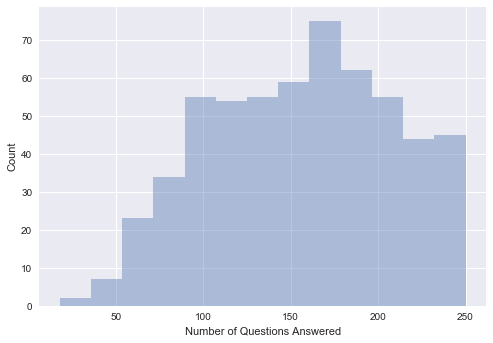

count    570.00
mean     156.26
std       52.75
min       18.00
25%      118.00
50%      158.50
75%      197.00
max      250.00
dtype: object

In [201]:
num_answers_per_person = df_answered_pivot.count(axis=1)

# distribution of number of answers per survey
sns.distplot(num_answers_per_person.dropna(), kde=False)
plt.xlabel('Number of Questions Answered')
plt.ylabel('Count')
plt.show()

num_answers_per_person.describe().apply('{:,.2f}'.format)

So the remaining data points seem to accurately reflect our usable data set, but now the quality/usability of that data is called into doubt. Before we clean up the data further (decide how to handle NaNs), we need to assess what type of data we're working with (measurement scale), and as a result, the available/appropriate tests we'll be using the data for.

Determining whether our survey results most appropriately reflect interval data (as it was collected) or [discrete] ordinal data (categorical data, where the values don't necessarily have equal "distance") is somewhat challenging in this case, and extremely important.  If we determine that our data is ordinal, parameters such as mean and standard deviation will likely be invalid, and any parametric analyses (generally considered to have more statistical power) based on the normal distribution will be impossible. Rather, rank, median, and range and associated tests (such as classification) will be the extent of our toolkit. The “intervalness” of the data is an attribute of the data, not of the labels.

The primary distinguishing factor will be whether the "distance" between responses is equal and meaningful. The edge cases in specific will be the determining factor: is the distance between 0 and 1 (never eat and very, very rarely eat) the same as 1 to 2 (very, very rarely eat to very rarely eat)? Unfortunately it seems logical that those distances are not the same (although survey partcipants may have mentally been assuming such equal increments in attempting to place the scale). You can eat "infinitely" more of a food at 1 than 0 (i.e. how can you even measure the distance from always to anything less than always?), bounded only by the normal quantities of food people can/want to eat. As a result of the fact that distances are inherently unequal, it would seem that the data should be treated as ordinal (and for testing purposes, therefore, largely categorical).

However the answer to this question is actually highly controvetial in the field of statistics, with Likert survey results (usually five or seven options, presented as variations on 'Always,' 'Sometimes,' 'Never') being the primary focus of that debate/research. The scope of the debate is beyond the pervue of this report, but the ultimate "answer" to the debate is that in at least some cases (particularly when we have data collected from a label-less, continuous, sliding scale, as with our survey data; see sample image below), interval-type parametric analysis is robust enough with respect to violations of its core assumptions that it can appropriately be run on Likert-style survey data. As a result, we will cautiously attempt to analyze the data assuming interval measurement in some cases (understanding the limitations of mean and variance as descriptive statistics).

* [Analyzing and Interpreting Data From Likert-Type Scales](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3886444/)
* [Likert scales, levels of measurement and the "laws" of statistics](https://www.scribd.com/document/344028976/Likert-scales-levels-of-measurement-and-the-laws-of-statistics-pdf)
* [How to Use the Likert Scale in Statistical Analysis](https://statisticscafe.blogspot.it/2011/05/how-to-use-likert-scale-in-statistical.html?m=1)
* [Parametric tests and Likert Scales (Ordinal data) - Two different views](https://stats.stackexchange.com/questions/175848/parametric-tests-and-likert-scales-ordinal-data-two-different-views)

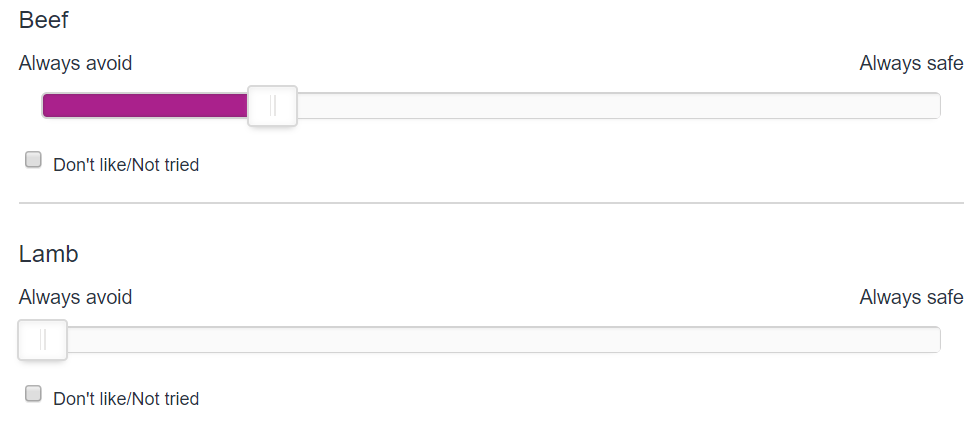

That said, and even assuming we have interval data, the facts that 1) the data was collected on a integer basis (as opposed to continuous) and 2) the probability distibutions of each of the food's responses are non-normal (and not normalizable without material and potentially biasing transformations) potentially severely limit the ability to utilize the more statistically powerful tests we'd hoped to be able to use anyway (e.g. regressions). See below for some of the supporting statistics:

In [202]:
question_answer_summary = df_answered_pivot.describe()
question_answer_summary.applymap('{:,.2f}'.format)

name,Agave Nectar,Almond,Almond Milk,Anchovy,Apple,Apple Juice,Apricot,Artichokes,Asparagus,Aspartame,...,Watercress,Watermelon,Wheat,Whiskey,Wine - Champagne,Wine - Pink,Wine - Red,Wine - Sparkling,Wine - White,Yoghurt - Plain
count,180.00,448.00,229.00,161.00,550.00,497.00,362.00,198.00,395.00,306.00,...,327.00,453.00,516.00,295.00,417.00,414.00,360.00,426.00,433.00,495.00
mean,3.23,4.08,6.99,4.97,5.39,4.68,4.24,3.71,5.80,2.73,...,5.17,6.28,4.02,2.25,3.43,3.37,2.96,3.29,3.59,5.80
std,4.21,3.94,3.85,4.37,3.84,4.02,3.84,3.98,3.88,3.53,...,4.05,3.86,3.61,3.48,3.67,3.66,3.62,3.57,3.63,3.97
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,5.00,0.00,2.00,0.00,0.00,0.00,2.00,0.00,...,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,0.00,4.00,10.00,5.00,5.00,5.00,4.00,2.00,6.00,1.00,...,5.00,7.00,4.00,0.00,2.00,2.00,1.00,2.00,3.00,6.00
75%,8.00,8.00,10.00,10.00,10.00,10.00,7.75,7.00,10.00,5.00,...,10.00,10.00,6.00,5.00,6.00,6.00,5.00,6.00,6.00,10.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00


In [203]:
# run tests for normality
tally = 0
for i in range(df_answered_pivot.shape[1]):
    statistic, p_val = scipy.stats.normaltest(df_answered_pivot.iloc[:,i], nan_policy='omit')
    if (p_val > 0.05 and statistic != '--'):  # low p-value indicates it's unlikely the data came from a normal distribution
        print(i, p_val, statistic)
        tally += 1

print('{0} normal distributions found.'.format(tally))
# ALSO use scipy.stats.shapiro shapiro-wilk test

C:\Anaconda\lib\site-packages\scipy\stats\mstats_basic.py:2254: RuntimeWarning: divide by zero encountered in true_divide
  term2 = ma.power((1-2.0/A)/denom,1/3.0)


0 normal distributions found.


Though as long as we're looking at the data, there are a couple observations we can fairly make now: at first glance it seems like there are no universally tolerated/untolerated foods:

In [204]:
print('There are no foods that everyone could tolerate.' if question_answer_summary.loc['min'].max() == 0 else 'There ARE foods that everyone could tolerate.')
print('There are no foods that noone could tolerate.' if question_answer_summary.loc['max'].min() == 10 else 'There ARE foods that noone could tolerate.')

There are no foods that everyone could tolerate.
There are no foods that noone could tolerate.


Lastly, and now that we've determined our data will be "cautiously"  interval (but otherwise ordinal), we can drop missing data from our data set (as most methods of analysis we'll be able to run have difficulty with missing data). However, given the sparcity of our data, that's not such an easy task. We've already established that not a single food had an answer given by every participant, and that only 19 people answered all 250 questions. What we're left with is a [multi-objective optimization problem](https://en.wikipedia.org/wiki/Multi-objective_optimization).

The maximum number of surveys for each food count and/or maximum number of foods for each survey count all reflect "optimal" solutions. Of those "optimal" choices, we then need to use judgement to select the most appropraite choice(es). To make that decision easier, we can plot the options on what's known as a '[Pareto Frontier](https://en.wikipedia.org/wiki/Pareto_efficiency)' or a 'Tradeoff Curve':

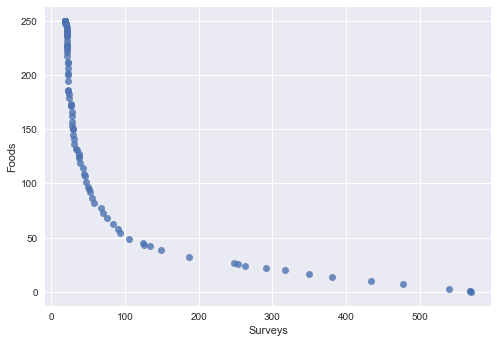

,Missing Survey Percentage,Surveys,Foods
39,0.39,22,212
42,0.42,23,202
49,0.49,26,173
52,0.52,28,166
59,0.59,31,141
61,0.61,34,132
63,0.63,37,127
66,0.66,39,119
67,0.67,43,114
68,0.68,44,109


In [205]:
l=[]
for missing_survey_perc in np.linspace(0.00, 1.00, num=101):
    df_before_preprocessing = df_answered_pivot.dropna(thresh=missing_survey_perc*len(df_answered_pivot), axis=1)
    l.append([missing_survey_perc, df_before_preprocessing.dropna().shape[0], df_before_preprocessing.dropna().shape[1]])

pareto = pd.DataFrame(l, columns=['Missing Survey Percentage', 'Surveys', 'Foods'])
sns.regplot(x=pareto['Surveys'], y=pareto['Foods'], fit_reg=False)
plt.show()

# plot summary of table:
pareto.loc[(pareto['Foods'].diff() < -3) & (pareto['Surveys'].diff() > 0)]

Note that rather than going through the complex multi-objective optimization, we opted to use a built-in parameter of panda's dropna() which allows you to drop rows or columns based on the percentage filled in that row or column. By checking in increments of 1%, our table should come fairly close to optimal for significantly less computational cost.

From there deciding is somewhat arbitrary, but given our already limited dataset, and that we want our sample size to be as large as possible for the sake of statistical power (especially considering our data scale), the three seemingly most useful options are dropping columns where there aren't 87% 88%, or 95% of rows filled (see table above for associated numbers of surveys and foods). We could work with one set at a time and swap out for a different choice later, but it's easy enough to create the dataframes for each option, saving them in a dictionary that we can iterate through for each analysis later:

In [206]:
df_dict = {}

thresh_dict = {'32':0.87, '27':0.88, '10':0.95}

for food_count, thresh in thresh_dict.items():
    df_dict['df_{0}foods'.format(food_count)]= df_answered_pivot.dropna(thresh=thresh*len(df_answered_pivot), axis=1).dropna(axis=0)

print('List of dataframes in our dictionary: ',[k for k in df_dict.keys()])
print('Let\'s make sure our 27 food dataframe\'s shape looks right: ', df_dict['df_27foods'].shape)
df_dict['df_27foods'].tail()

List of dataframes in our dictionary:  ['df_32foods', 'df_27foods', 'df_10foods']
Let's make sure our 27 food dataframe's shape looks right:  (248, 27)


name,Apple,Bananas,Beef,Broccoli,Butter,Carrots,Cheese - Hard,Chicken,Chicken Egg,Chocolate - Milk,...,Orange,Orange Juice (without bits),Peas,"Potatoes, White","Rice, White",Strawberries,Sugar,Tap Water,Tomatoes,Wheat
user_id,,,,,,,,,,,,,,,,,,,,,
3512,8.0,10.0,7.0,4.0,0.0,10.0,0.0,9.0,8.0,2.0,...,5.0,3.0,0.0,3.0,2.0,1.0,4.0,0.0,2.0,6.0
3513,8.0,10.0,6.0,2.0,2.0,8.0,6.0,9.0,9.0,1.0,...,9.0,9.0,0.0,3.0,1.0,7.0,0.0,10.0,8.0,1.0
3525,5.0,5.0,5.0,5.0,0.0,5.0,3.0,10.0,5.0,2.0,...,5.0,0.0,3.0,5.0,5.0,6.0,0.0,10.0,5.0,5.0
3539,10.0,10.0,0.0,10.0,0.0,7.0,0.0,0.0,3.0,6.0,...,10.0,10.0,9.0,0.0,0.0,9.0,0.0,10.0,10.0,0.0
3544,4.0,6.0,9.0,5.0,10.0,10.0,10.0,10.0,10.0,9.0,...,10.0,3.0,1.0,10.0,10.0,0.0,10.0,10.0,5.0,2.0


With that, we have a fully scrubbed data set to work with. Our one last step is to preprocess the data for our planned analysis.

# IBD Survey Data Preprocessing

While our data is already scaled to a common range, we will employ the [MinMaxScaler](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler) (which in our case, given that every food has a 0 minimum and 10 maximum effectively just divides by 10 for our data), for a couple of reasons:
1. Some of our algorithms will run more quickly as a result of scaling and
2. Having all values between zero and one gives us a nice, easy option to convert the sometimes data (1-9) to either 0 or 1 via rounding, so we can look at foods on a simple can/can't eat basis.

In [207]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

for k in [k for k in df_dict.keys()]:
    if 'scaled' not in k:
        df = df_dict.pop(k)
        v = min_max_scaler.fit_transform(df)
        df_dict[k+'_scaled'] = pd.DataFrame(v, columns=df.columns)
    else:
        print('This df is already scaled.')

df_dict['df_27foods_scaled'].tail()

#loses the user ID with this step - find solution

name,Apple,Bananas,Beef,Broccoli,Butter,Carrots,Cheese - Hard,Chicken,Chicken Egg,Chocolate - Milk,...,Orange,Orange Juice (without bits),Peas,"Potatoes, White","Rice, White",Strawberries,Sugar,Tap Water,Tomatoes,Wheat
243,0.8,1.0,0.7,0.4,0.0,1.0,0.0,0.9,0.8,0.2,...,0.5,0.3,0.0,0.3,0.2,0.1,0.4,0.0,0.2,0.6
244,0.8,1.0,0.6,0.2,0.2,0.8,0.6,0.9,0.9,0.1,...,0.9,0.9,0.0,0.3,0.1,0.7,0.0,1.0,0.8,0.1
245,0.5,0.5,0.5,0.5,0.0,0.5,0.3,1.0,0.5,0.2,...,0.5,0.0,0.3,0.5,0.5,0.6,0.0,1.0,0.5,0.5
246,1.0,1.0,0.0,1.0,0.0,0.7,0.0,0.0,0.3,0.6,...,1.0,1.0,0.9,0.0,0.0,0.9,0.0,1.0,1.0,0.0
247,0.4,0.6,0.9,0.5,1.0,1.0,1.0,1.0,1.0,0.9,...,1.0,0.3,0.1,1.0,1.0,0.0,1.0,1.0,0.5,0.2


Let's already create variations of each of our dataframes where the classification groupings are consolidated according to the following additional schemes:
* Where all values 0.0-0.9 are treated as 0 (can't eat), leaving scores of 1.0 as they are (can eat). This will let us conclude with greater confidence that a food CAN be eaten after our analysis.
* Where 0.0 is left as is (can't eat), changing all scores of 0.1-1.0 to 1.0 (can eat). This will let us conclude with greater confidence that a food CAN'T be eaten after our analysis.
* Where there are three distinct categories, leaving 0.0 and 1.0 as they are, but treating scores 0.1-0.9 as a third category. This will help us remove potential noise from the survey results.
* 0 vs 1 vs unknown

We will do the same for df_answered_pivot, which is the table that still has missing values, because we will use that dataset for pairwise analysis.

In [208]:
for k in [k for k in df_dict.keys()]:
    if '_0' not in k:
        df_dict[k+'_0-9v10'] = df_dict[k].applymap(np.floor)
        df_dict[k+'_0v1-10'] = df_dict[k].applymap(np.ceil)
        df_dict[k+'_0v1-9v10'] = df_dict[k].copy()
        df_dict[k+'_0v1-9v10'][(df_dict[k+'_0v1-9v10']>0.0) & (df_dict[k+'_0v1-9v10']<1.0)] = 0.5

df_dict_pairwise = {}
df_dict_pairwise['df_250foods_scaled_0-9v10_nodrop'] = df_answered_pivot.applymap(lambda x: x/10).applymap(np.floor)
df_dict_pairwise['df_250foods_scaled_0v1-10_nodrop'] = df_answered_pivot.applymap(lambda x: x/10).applymap(np.ceil)

df_dict['df_27foods_scaled_0v1-9v10'].tail()

name,Apple,Bananas,Beef,Broccoli,Butter,Carrots,Cheese - Hard,Chicken,Chicken Egg,Chocolate - Milk,...,Orange,Orange Juice (without bits),Peas,"Potatoes, White","Rice, White",Strawberries,Sugar,Tap Water,Tomatoes,Wheat
243,0.5,1.0,0.5,0.5,0.0,1.0,0.0,0.5,0.5,0.5,...,0.5,0.5,0.0,0.5,0.5,0.5,0.5,0.0,0.5,0.5
244,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.0,0.5,0.5,0.5,0.0,1.0,0.5,0.5
245,0.5,0.5,0.5,0.5,0.0,0.5,0.5,1.0,0.5,0.5,...,0.5,0.0,0.5,0.5,0.5,0.5,0.0,1.0,0.5,0.5
246,1.0,1.0,0.0,1.0,0.0,0.5,0.0,0.0,0.5,0.5,...,1.0,1.0,0.5,0.0,0.0,0.5,0.0,1.0,1.0,0.0
247,0.5,0.5,0.5,0.5,1.0,1.0,1.0,1.0,1.0,0.5,...,1.0,0.5,0.5,1.0,1.0,0.0,1.0,1.0,0.5,0.5


# IBD Survey Analysis with Machine Learning

With the multiple datasets we've created, we will try to answer our initial questions (reprinted from above):
1. Are there any identifiable sub-clusters of diet among the survey participants?
2. Are there relationships between individual foods or groups of foods? If so, can we 
  1. find common nutrient links between those foods? or 
  2. use that information to reduce the dimensionality of our features and improve our ability to predict food tolerance/intolerance?
3. Are there any nutrients, vitamins, or minerals that impact food tolerance?
4. Can food tolerance/intolerance be predicted with a reasonable degree of accuracy (ideally probability) for an IDB sufferer with only a few “known” safe/unsafe foods?

If there are any clusters, it'd be beneficial to identify those first, so as to improve the accuracy of later tests. And both annecodatally and logically we'd expect to find at least two overall diet clusters - for our two primary types of IBD (Ulcerative Colitis and Crohn's Disease). After that, we can look for other relationships in the data using unsupervised and supervised methods, followed by [hopefully] a recommendation system. The initial plan is as follows:
1. Use unsupervised techniques to identify clusters.
  1. Use cosine similarity to correct for our "distance" problem given the unequal distances from 0.0 to 0.1 and 0.9 to 1.0 versus the rest of the intervals.
  2. Run pairwise and overall dbscans to identify any clusters. 
  3. Use a combination of homogeneity, completeness (and combined into V-measure), and silhouette coefficient to evaluate potentially interesting results.
2. Identify relationships between foods using chi-squre + Cramer's V (phi) and ordinal logistic regression.
3. For every vitamin, look up the food's value. Rank the vitamin value by food (% of range max-min). By vitamin, compare all survey questions. X=% vitamin for food, y=0 or 1 for yes/no could/count't eat. Run logistic regression and chi-square for each vitamin. This can be run with the original column-style data.
4. Predict food tolerances using supervised machine learning techniques including apriori algorithm, ordinal regression, and random forest.

In [209]:
# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# from sklearn.preprocessing import StandardScaler
 
# %%time
# for i in range(df_answered_pivot.shape[1]):
#     for j in range(i+1, df_answered_pivot.shape[1]):
#         df = pd.concat([df_answered_pivot.iloc[:,i], df_answered_pivot.iloc[:,j]], axis=1).dropna()
        
#         X = pd.DataFrame({'f1': df.iloc[:,0].values})
#         labels_true = df.iloc[:,1].values

#         X = StandardScaler().fit_transform(X)
#         db = DBSCAN(eps=0.3, algorithm='brute', metric='cosine', min_samples=10).fit(X)

#         labels = db.labels_
#         n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        
#         if metrics.v_measure_score(labels_true, labels) > 0.5:
            
#             unique_labels = set(labels)
#             colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
           
#             for _ in range(len(X)):
#                 if labels[_] == -1:
#                     plt.scatter(X[_], labels_true[_], c='k', marker="o", s=32)
#                 else:
#                     plt.scatter(X[_], labels_true[_], c=colors[labels[_]], marker="o", s=64)
            
#             plt.title('Comparing {0} and {1}'.format(df_answered_pivot.columns[i], df_answered_pivot.columns[j]),
#                       fontsize=14, fontweight='bold')
#             plt.xlabel(df_answered_pivot.columns[i])
#             plt.ylabel(df_answered_pivot.columns[j])
            
#             plt.show()
            
#             print('Estimated number of clusters: %d' % n_clusters_)
#             print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#             print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#             print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#             print("Adjusted Rand Index: %0.3f"
#                   % metrics.adjusted_rand_score(labels_true, labels))
#             print("Adjusted Mutual Information: %0.3f"
#                   % metrics.adjusted_mutual_info_score(labels_true, labels))
#             print("Silhouette Coefficient: %0.3f \n"
#                   % metrics.silhouette_score(X, labels))

# print('Done')

Very few clusters were identified in any of the pairwise combinations of foods with any real confidence, and the few that were identified (above) are for the foods with the least responses that are likely the rarest eaten - and where data is sparsest and potentially least reliable.  Additionally, the foods with clusters are not features in our more concentrated datasets that we'll be able to use for our later questions. Viewing the scatterplots of pairwise relationships, it becomes clear that answers are too heterogeneous to reasonably determine any kind of unique clusters in most cases. While our data can't say difinitely that there are no clusters in many of the pairs, it seems improbably, and certainly won't be identifiable in our dataset.

In [210]:
%%time
from sklearn.cluster import KMeans

#cosine_similarity first to adjust distance issues 0-1 and 9-10

X = df_dict['df_27foods_scaled']
# print(X)
# X.dropna(inplace=True)

kmeans = KMeans(n_clusters=4).fit(X)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_

# Categorizes users into clusters based on all 27 remaining foods
print(labels)
# print("\n V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))

[1 3 2 2 0 1 0 3 3 2 3 2 1 1 2 0 0 2 3 0 0 0 3 1 0 1 0 2 3 1 1 1 3 3 2 2 2
 2 2 3 0 1 1 2 0 0 1 3 0 0 3 0 1 1 0 2 2 0 1 0 0 0 0 0 3 2 1 2 3 0 1 0 0 3
 3 0 2 1 3 0 0 3 1 1 1 1 3 3 2 3 3 0 1 3 2 1 2 1 0 2 0 0 0 0 1 0 3 2 3 1 0
 3 2 2 2 2 0 2 2 2 3 0 0 0 1 1 3 0 1 0 3 3 2 2 1 1 0 1 2 3 1 3 1 3 3 1 3 2
 1 3 1 0 2 0 0 2 0 3 1 0 1 0 3 1 3 1 0 2 3 0 3 1 2 3 1 0 3 2 2 3 1 3 0 1 0
 0 2 3 1 3 1 1 1 3 2 2 3 3 0 0 1 2 2 3 0 1 0 2 2 0 0 0 2 3 3 1 1 3 1 1 2 2
 1 1 0 0 2 2 3 3 2 1 2 1 3 1 2 2 2 2 2 2 2 2 3 2 3 0]
Wall time: 67.2 ms


In [211]:
# %%time
# from scipy.stats import chi2_contingency

# for k in [k for k in df_dict_pairwise.keys()]:
#     df = df_dict_pairwise[k]
#     for i in range(df.shape[1]):
#         for j in range(i+1, df.shape[1]):
#             pair_df = pd.concat([df.iloc[:,[i]], df.iloc[:,[j]]], axis=1).dropna()
#             columns = list(pair_df)
#             groupsizes = pair_df.groupby([columns[0], columns[1]]).size()
#             ctsum = groupsizes.unstack(columns[0])
#             if chi2_contingency(ctsum.fillna(0))[1] < 0.05:
#                 print(ctsum)
#                 print(chi2_contingency(ctsum.fillna(0)))

In [212]:
# for k in [k for k in df_dict.keys()]:
#     df = df_dict[k]
#     for i in range(df.shape[1]):
#         for j in range(i+1, df.shape[1]:
#             print(df.iloc[:,i], df.iloc[:,j])
#             # cosine of pair
#             # run pairwise tests for foods (columns) i and j
#             # capture i, j, performance evaluation in db table

Let's see if we can make some predictions using the apriori algorithm. First, we will use our 0-9v10 dataset. Technically we could actually use our entire dataset, since we'll be removing non-10 (or 1.0 in the scaled case) data, but the apriori algorithm has difficulty with especially spare data, so we will save such analysis for later.

What we hope to answer is for foods that can definitely be eaten (10) can we find common subsets of foods that occur frequently (known as "support"), with confidence (known as "confidence"), and more often than would be expected by random chance (known as "lift"):

In [213]:
%%time
import json
import sys
from fim import fpgrowth
from sklearn.cross_validation import train_test_split


def df_to_association_input(df):
    #Convert df to acceptable input format for apyori.apriori()
    transactions = df.copy()
    for col in transactions.columns:
        transactions[col].replace([1, 0.5, 0], [col, '', 'not '+col], inplace=True)

    transactions = transactions.values.tolist()

    for i, entry in enumerate(transactions):
        transactions[i][:] = filter(bool, entry)
    
    return transactions  # transactions_train, transactions_test

    
# todo create loop for each of 0-9v10, 0v1-10 and 0v1-9v10
df_input = df_dict['df_32foods_scaled_0v1-9v10']
association_input = df_to_association_input(df_input)
association_train, association_test = train_test_split(association_input, test_size=0.2)

rules_df = pd.DataFrame(fpgrowth(association_train, target='r', supp=-30, conf=80, report='bCl',
                                 eval='l', agg='n', thresh=0, appear={'Filtered Water': '-', 'Tap Water': '-'}),
                        columns=['Consequent', 'Antecedents', 'Support (Count)', 'Confidence (%)','Lift (x)'],
                        index=None, copy=False)

print('Length of training set: ', len(association_train))
print('Number of rules: ', len(rules_df))
print('Bytes of memory used: ', sys.getsizeof(rules_df), '\n')

rules_df.to_csv('association_rules.csv')

Length of training set:  149
Number of rules:  1227
Bytes of memory used:  175227 

Wall time: 117 ms


In [214]:
rules_df.head()

,Consequent,Antecedents,Support (Count),Confidence (%),Lift (x)
0,Chicken,"(Potatoes, White,)",79,82.278481,1.250969
1,Chicken,"(Rice, White,)",72,87.500000,1.330357
2,Chicken,"(Rice, White, Potatoes, White)",58,93.103448,1.415552
3,"Potatoes, White","(Rice, White, Chicken)",63,85.714286,1.616637
4,"Rice, White","(Potatoes, White, Chicken)",65,83.076923,1.719231


Let's take a look at what kinds of rules we produced:

In [235]:
# We'll make a function of this so we can rerun it later
def summary_table(df):
    df = df.groupby(['Consequent']).agg({'Antecedents': lambda ante: list(ante),
                                         'Support (Count)': [np.min, 'mean', np.max], 
                                         'Confidence (%)': [np.min, np.mean, np.max], 
                                         'Lift (x)': [np.min, np.mean, np.max]
                                        }).reset_index()

    # text formatting currently not working
    df.style.format({'Support (Count)': '{:.2f}', 'Confidence (%)': '{:.2f}', 'Lift (x)': '{:.2f}'})

    cm = sns.light_palette("green", as_cmap=True)
    df = df.style.background_gradient(cmap=cm)
    
    return df


summary_table(rules_df)

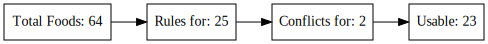

In [216]:
def check_conflicting_rules(rule_consequent_set):
    not_foods = set()
    reg_foods = set()
    for food in rule_consequent_set:
        if 'not ' == food[0:4]:
            not_foods.add(food)
        else:
            reg_foods.add(food)

    return [x for x in reg_foods if 'not '+x in not_foods] + [y for y in not_foods if y[4:] in reg_foods]

total_foods = df_input.columns.tolist() + ['not '+x for x in df_input.columns.tolist()]
rules_for = grouped_rules_df['Consequent'].tolist()
conflicts = check_conflicting_rules(grouped_rules_df['Consequent'].tolist())
possible = [x for x in rules_for if x not in conflicts]

d1 = gv.Digraph(node_attr={'shape':'box'}, graph_attr={'rankdir': 'LR'})

d1.node(str(total_foods), 'Total Foods: {}'.format(len(total_foods)))
d1.node(str(rules_for), 'Rules for: {}'.format(len(rules_for)))
d1.node(str(conflicts), 'Conflicts for: {}'.format(len(conflicts)))
d1.node(str(possible), 'Usable: {}'.format(len(possible)))
d1.edge(str(total_foods), str(rules_for))
d1.edge(str(rules_for), str(conflicts))
d1.edge(str(conflicts), str(possible))
d1

We will exclude conflicting rules from our potential recommendations, since the methods of resolving the conflicts are largely subjective (done below).

The final number of possible recommendations reflect all food or not-food recommendations we're above to make with "confidence," and reflects a remarkable ~1/3 of the possible foods/not foods.

In [237]:
# remove rules with consequents in our conflicts set.
# drop row if consequent in conflicts
print('Number of rules before: {}'.format(len(rules_df)))

rules_df_noconflict = rules_df[~rules_df['Consequent'].isin(conflicts)]

print('Number of rules after: {}'.format(len(rules_df_noconflict)))

Number of rules before: 1227
Number of rules after: 1224


Now that we've removed out conflicts, let's check out our summary table again:

In [236]:
summary_table(rules_df_noconflict)

Now we want to see how accurate our results are, so that we might compare to other methods of recommendation. In this regard, association rules are largely self-validating. That is to say, our measures of interestingness, particularly confidence, already reflect how "accurate" our rules are for all included data.

That said, we take the approach of cross-validating below, in which 1) the data is divided into training and test sets, 2) each transaction in the test set has rules (from the training set) that are subsets of the transaction tested for accuracy, and 3) 'correct', 'incorrect', 'new recommendations', and 'missed opportunities' are tracked. In effect, this method of cross validation should provide validation in our measures of interestingness or second order validation (i.e. validation of validation). 

In [240]:
# Validate transactions in association_train for accuracy using association_test

def generate_recommendations(transaction_input):
    # checks every transaction input for rules where the antecedents are a subset of the transaction
    # allows us to check the recommendations from those rules to see if they're accurate
    for rule in [r for idx, r in rules_df.iterrows()]:
        if set(rule['Antecedents']).issubset(transaction_input):
            yield rule
    
test = association_test

print('Length of test set is: ', len(test))
print('Max possible food recommendations for each transaction is: {}\n'.format(possible))

for transaction in test:
    rule_list = []
    rec_list = []
    new_rec = 0
    
    '''
    Both correct and incorrect implicity assume all rules for a specific food make the same recommendation. To ensure
    accuracy this requires conflicts to be removed from training set first.
    '''
    correct = 0  
    incorrect = 0
    
    for rule in generate_recommendations(transaction): # all recommended foods based on being a subset of transaction
        rule_list.append(rule)
        rec_list.append(rule['Consequent'])
    
    for i in set(rec_list):
        if i != transaction:
            if i not in transaction:
                if 'not ' == i[0:4]:
                    if i[4:] in transaction:
                        incorrect += 1
                    else:
                        new_rec += 1
                else:
                    if 'not '+i in transaction:
                        incorrect += 1
                    else:
                        new_rec += 1
            else:
                correct += 1
    
    # Adds to sum of correct, incorrect, and new recommendations to total possible recommendations             
    missed_opp = len(possible) - len(set(rec_list))
    
    accuracy = '{:.2f}%'.format(correct / (correct + incorrect) * 100) if (correct + incorrect != 0) else 'N/A'
    

    print('Number of rules that apply: {}'.format(len(rule_list)))
    print('Number of foods recommended: ', len(set(rec_list)))
    print('Recommended foods: ', set(rec_list))
    print('Correct: {0}, Incorrect: {1}, Accuracy: {2}'.format(correct, incorrect, accuracy))
    print('New Recommendations: {0}, Missed Opportunities: {1}\n'.format(new_rec, missed_opp))

Length of test set is:  38
Max possible food recommendations for each transaction is: ['Apple', 'Bananas', 'Broccoli', 'Butter', 'Carrots', 'Cheese - Hard', 'Cheese - Soft', 'Chicken', 'Chicken Egg', 'Chocolate - Milk', 'Cucumber', 'Garlic', 'Grapes', 'Lettuce', 'Onions', 'Peas', 'Pork', 'Potatoes, White', 'Rice, White', 'Strawberries', 'Tomatoes', 'not Apple Juice', 'not Orange Juice (without bits)']

Number of rules that apply: 5
Number of foods recommended:  3
Recommended foods:  {'not Apple Juice', 'not Orange', 'not Orange Juice (without bits)'}
Correct: 3, Incorrect: 0, Accuracy: 100.00%
New Recommendations: 0, Missed Opportunities: 20

Number of rules that apply: 155
Number of foods recommended:  11
Recommended foods:  {'Cheese - Soft', 'Chocolate - Milk', 'Potatoes, White', 'Cheese - Hard', 'Lettuce', 'Butter', 'Chicken', 'Carrots', 'Chicken Egg', 'Bananas', 'Rice, White'}
Correct: 6, Incorrect: 1, Accuracy: 85.71%
New Recommendations: 4, Missed Opportunities: 12

Number of rul

Number of foods recommended:  20
Recommended foods:  {'Cucumber', 'Apple', 'Peas', 'Onions', 'Potatoes, White', 'Garlic', 'Orange', 'Grapes', 'Lettuce', 'Butter', 'Tomatoes', 'Broccoli', 'not Apple Juice', 'not Orange Juice (without bits)', 'Chicken', 'Carrots', 'Strawberries', 'Chicken Egg', 'Bananas', 'Rice, White'}
Correct: 18, Incorrect: 2, Accuracy: 90.00%
New Recommendations: 0, Missed Opportunities: 3

Number of rules that apply: 60
Number of foods recommended:  5
Recommended foods:  {'Potatoes, White', 'Chicken', 'Carrots', 'Bananas', 'Rice, White'}
Correct: 4, Incorrect: 0, Accuracy: 100.00%
New Recommendations: 1, Missed Opportunities: 18

Number of rules that apply: 1209
Number of foods recommended:  22
Recommended foods:  {'Apple', 'Chocolate - Milk', 'Orange', 'Garlic', 'Grapes', 'Lettuce', 'Broccoli', 'Carrots', 'Cucumber', 'Tomatoes', 'Chicken', 'Butter', 'Bananas', 'Cheese - Soft', 'Onions', 'Cheese - Hard', 'Strawberries', 'Chicken Egg', 'Rice, White', 'Pork', 'Peas', 

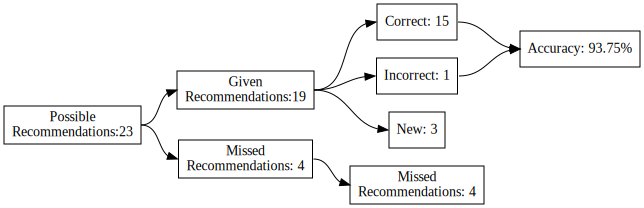

In [241]:
d = gv.Digraph(node_attr={'shape':'box', 'pos':'r'}, graph_attr={'rankdir': 'LR'}, edge_attr={'headport':'w', 'tailport':'e'})

d.node('A', 'Possible\nRecommendations:{}'.format(len(possible)))
d.node('B', 'Given\nRecommendations:{}'.format(len(set(rec_list))))
d.node('C', 'Missed\nRecommendations: {}'.format(missed_opp))
d.node('D', 'Correct: {}'.format(correct))
d.node('E', 'Incorrect: {}'.format(incorrect))
d.node('F', 'New: {}'.format(new_rec))
d.node('G', 'Accuracy: {}'.format(accuracy))
d.node('H', 'Missed\nRecommendations: {}'.format(missed_opp))
d.edges(['AB', 'AC', 'BD', 'BE', 'BF', 'DG', 'EG', 'CH'])
d

# todo add hover for each that shows foods

Our cross validation (accuracy) reflects an essessment of the accuracy of the confidence parameter. I.e. how the confidence parameter used for our training set matches up with the acctual occurences in the test data. E.g. an 80% confidence should be correct 80% of the time.